CIFAR-100
=====

CIFAR-100 데이터를 이용한 Image classification 연습
---------------------------------------------

---

<center>
<h2>[Fractional Max-Pooling](https://arxiv.org/abs/1412.6071)</h2>   

Benjamin Graham   
Dept of Statistics, University of Warwick, CV4 7AL, UK   
b.graham@warwick.ac.uk   
May 13, 2015   
   

arXiv:1412.6071v4 [cs.CV] 12 May 2015   
</center>

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import prettytensor as pt
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import math
import os
import cifar100

## 데이터 불러오기

In [2]:
cifar100.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


cifar100 데이터는 32X32 크기의 사진 6만장이 들어있다.  
그 중 5만장은 Test set, 1만장은 Test set 으로 구성되어 있다.  
이미지의 class 는 100개이고 각 class 마다 균등하게 배분되어 있다.

사실 CIFAR100은 상위 클레스가 존재하는 데 20개로 구성되어 있고, 하위로 각 5개씩 존재해서 100개인 것이다.  
상위 클레스로 20개만 사용하고 싶으면 cifa100.py에  다음과 같이 대체하자. 
* label에 "coarse_labels"
* meta에 "coarse_label_names"

In [3]:
class_names = cifar100.load_class_names()
class_names[:10]

Loading data: data/CIFAR-100/cifar-100-python/meta


['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

각 data set을 로드한다. Training set은 용량 문제로 5개의 배치파일로 분리되어 있다.

In [4]:
images_train, cls_train, labels_train = cifar100.load_training_data()

Loading data: data/CIFAR-100/cifar-100-python/train


Load the test-set.

In [5]:
images_test, cls_test, labels_test = cifar100.load_test_data()

Loading data: data/CIFAR-100/cifar-100-python/test


In [6]:
print("Size of:")
print("- Training-set:\t{}".format(len(images_train)))
print("- Test-set:\t{}".format(len(images_test)))

Size of:
- Training-set:	50000
- Test-set:	10000


### Data Dimensions

In [7]:
from cifar100 import img_size, num_channels, num_classes

In [8]:
img_size_cropped = 52

### 데이터가 올바른지 확인하기 위해 몇가지 이미지를 확인한다.

3x3 그리드에 9개의 이미지를 그리는 데 사용되는 함수이며, 각 이미지 아래의 실제 및 예상 class를 보여준다.

In [9]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)

    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
        
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        ax.imshow(images[i, :, :, :], interpolation=interpolation)
            
        cls_true_name = class_names[cls_true[i]]

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

다음 사진은 test set의 처음 9개의 사진이다.

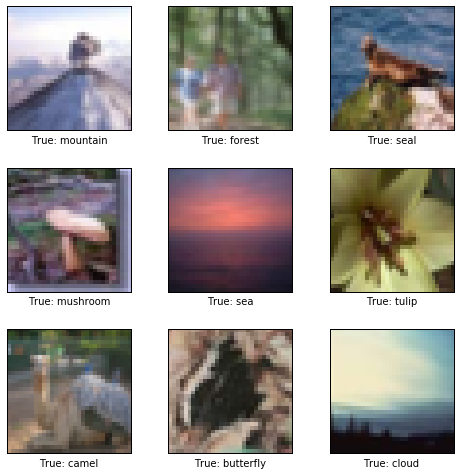

In [10]:
images = images_test[0:9]
cls_true = cls_test[0:9]

plot_images(images=images, cls_true=cls_true, smooth=False)

plt 패키지의 spline16를 이용해서 사진을 부드럽게 만들 수 있다.

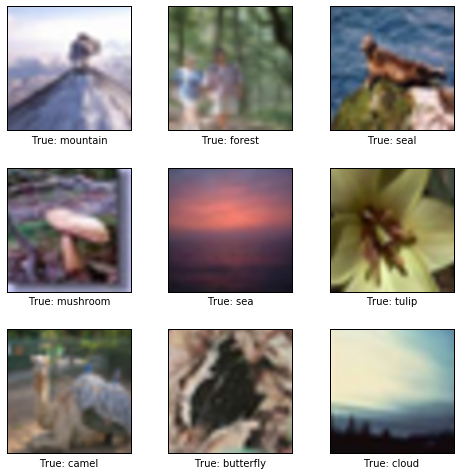

In [11]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow Graph

### Placeholder variables

In [12]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, 1)

### 이미지 전처리 작업

In [13]:
def pre_process_image(image, training):
    
    if training:
        # 랜덤하게 부분적으로 잘라낸다.
        # image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        
        # 랜덤하게 좌우 반전 한다.
        image = tf.image.random_flip_left_right(image)
        
        # 랜덤하게 색상, 대비, 밝기, 채도를 조정한다.
        image = tf.image.random_hue(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

        # 너무 심하게 바뀐 경우를 대비해 1과 0 사이값으로 맞춘다.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
        
        # DeepNiN 이미지 확장용 Padding
        image = tf.image.resize_image_with_crop_or_pad(
            image, target_height=img_size_cropped, target_width=img_size_cropped)
    else:
        # 테스트시 중앙을 기준으로 이미지를 23x23으로 자른다.
        image = tf.image.resize_image_with_crop_or_pad(
            image, target_height=img_size_cropped, target_width=img_size_cropped)

    return image

In [14]:
def pre_process(images, training):
    
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    
    return images

In [15]:
distorted_images = pre_process(images=x, training=True)

In [16]:
distorted_images

<tf.Tensor 'map/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 52, 52, 3) dtype=float32>

### [Fractional Max-Pooling - paper](https://arxiv.org/abs/1412.6071)

위 논문은 Fractional Max-Pooling을 소개한다.   
아래 알고리즘은 논문에서 CIFAR 100 - Accuracy : 73.61% 를 달성한 CNN 구조이다.

### (64nC2 − FMP√2)*7

```
input[52x52]−64C2 − FMP√2
            −128C2 − FMP√2
            −192C2 − FMP√2
            −256C2 − FMP√2
            −320C2 − FMP√2
            −384C2 − FMP√2
            −448C2 − FMP√2
            -512C2 - 1024C1 - output
```

In [17]:
def lrelu(x, alpha=1/3, name="lrelu"):
    with tf.variable_scope(name):
        x = tf.maximum(x, alpha * x)
        return x

In [18]:
@pt.Register
def FracionalMP(tensor, ratio=1.4, pseudo=True, ovlp=True, name="fmp"):
    with tf.variable_scope(name):
        pool = tf.nn.fractional_max_pool(
            value =tensor,
            pooling_ratio=[1.0, ratio, ratio, 1.0],
            pseudo_random=pseudo,
            overlapping=ovlp)
        head = pool.output
        
        return tensor.with_tensor(head)

In [19]:
def main_network(images, training):
    x_pretty = pt.wrap(images)

    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    with pt.defaults_scope(activation_fn=tf.nn.elu, phase=phase):
        y_pred, loss = (
            x_pretty
            
            .conv2d(kernel=2, depth=64, name='layer_conv1_1').dropout(1.0)
            .FracionalMP(ratio=1.4, pseudo=True, ovlp=True)

            .conv2d(kernel=2, depth=128, name='layer_conv2_1').dropout(1.0)
            .FracionalMP(ratio=1.4, pseudo=True, ovlp=True)

            .conv2d(kernel=2, depth=192, name='layer_conv3_1').dropout(0.9)
            .FracionalMP(ratio=1.4, pseudo=True, ovlp=True)

            .conv2d(kernel=2, depth=256, name='layer_conv4_1').dropout(0.8)
            .FracionalMP(ratio=1.4, pseudo=True, ovlp=True)

            .conv2d(kernel=2, depth=320, name='layer_conv5_1').dropout(0.7)
            .FracionalMP(ratio=1.4, pseudo=True, ovlp=True)

            .conv2d(kernel=2, depth=384, name='layer_conv6_1').dropout(0.6)
            .FracionalMP(ratio=1.4, pseudo=True, ovlp=True)

            .conv2d(kernel=2, depth=448, name='layer_conv7_1').dropout(0.5)
            .FracionalMP(ratio=1.4, pseudo=True, ovlp=True)

            .conv2d(kernel=2, depth=512, name='layer_conv8_1')
            .conv2d(kernel=1, depth=1024, name='layer_conv9_1')

            .flatten()

            .softmax_classifier(num_classes=num_classes, labels=y_true))

    return y_pred, loss

In [20]:
def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        
        images = pre_process(images=x, training=training)
        
        y_pred, loss = main_network(images=images, training=training)
        
    return y_pred, loss

### Training

만약 saver load가 있다면, 이전 step에 더해서 진행된다.

In [21]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

In [22]:
_, loss = create_network(training=True)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)

### Test / Pred

In [23]:
y_pred, _ = create_network(training=False)

y_pred_cls = tf.argmax(y_pred, dimension=1)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
y_pred

In [25]:
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

### Saver

In [26]:
saver = tf.train.Saver()

### Weights

In [27]:
def get_weights_variable(layer_name):
    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

나중에 weights 그림을 그리기 위함

In [28]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1_1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2_1')

### Layer Outputs

In [29]:
def get_layer_output(layer_name):
    tensor_name = "network/" + layer_name + "/Elu:0"

    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [30]:
output_conv1 = get_layer_output(layer_name='layer_conv1_1')
output_conv2 = get_layer_output(layer_name='layer_conv2_1')

Tensor name 을 잘 모르겠다면, `[tensor.name for tensor in tf.get_default_graph().as_graph_def().node]` 으로 검색해보자.

## TensorFlow Run

메모리를 한번에 안잡기 위해서 `growth=True` 를 설정

In [31]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)

In [32]:
save_dir = 'cifar100-checkpoints/'

In [33]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [34]:
save_path = os.path.join(save_dir, 'FractionalMP')

In [35]:
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from cifar100-checkpoints/FractionalMP-40000
Restored checkpoint from: cifar100-checkpoints/FractionalMP-40000


### random training-batch

In [36]:
batch_size = 500

In [37]:
def random_batch():
    num_images = len(images_train)

    idx = np.random.choice(num_images, size=batch_size, replace=False)

    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### optimization

In [38]:
def optimize(num_iterations):
    start_time = time.time()
    time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('Learning Start!', [time_now])

    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)

        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)

            msg = "Global Step: {0:>4}k, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(int(i_global/1000), batch_acc))
            
        
        if (i_global % 10000 == 0) or (i == num_iterations - 1):
            saver.save(session, save_path=save_path, global_step=global_step) # 5만번 마다 save
            
            time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("Saved checkpoint. [{}]".format(time_now))

    end_time = time.time()
    time_dif = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### plot example errors

Predict 시 못맞춘 것을 가지고와 보여준다.

In [39]:
def plot_example_errors(cls_pred, correct):

    incorrect = (correct == False)
    
    images = images_test[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### plot confusion matrix

In [40]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)
    
    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### calculating classifications

In [41]:
def predict_cls(images, labels, cls_true):
    num_images = len(images)

    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)

        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [42]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### classification accuracy

In [43]:
def classification_accuracy(correct):

    return correct.mean(), correct.sum()

### Test accuracy

In [44]:
correct, cls_pred = predict_cls_test()

In [45]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### plotting convolutional weights

In [46]:
def plot_conv_weights(weights, input_channel=0):
    
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

### plotting the output of convolutional layers

In [47]:
def plot_layer_output(layer_output, image):
    
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

## Examples of distorted input images

In [48]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    feed_dict = {x: image_duplicates}

    result = session.run(distorted_images, feed_dict=feed_dict)

    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [49]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [50]:
img, cls = get_test_image(16)

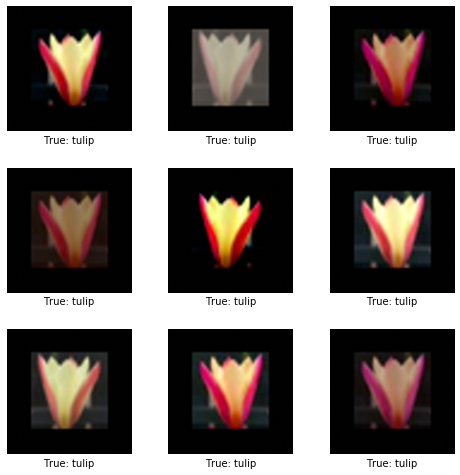

In [51]:
plot_distorted_image(img, cls)

## Perform optimization

## batch=500 / Step 1k == 10 Epoch
### Runing 200 Epoch / 

In [ ]:
# if True:
if False:
    optimize(num_iterations=100001)

Learning Start! ['2017-08-25 20:22:28']
Global Step:    1k, Training Batch Accuracy:   4.4%
Global Step:    2k, Training Batch Accuracy:  25.8%
Global Step:    3k, Training Batch Accuracy:  27.8%
Global Step:    4k, Training Batch Accuracy:  36.4%
Global Step:    5k, Training Batch Accuracy:  32.2%
Global Step:    6k, Training Batch Accuracy:  40.6%
Global Step:    7k, Training Batch Accuracy:  41.0%
Global Step:    8k, Training Batch Accuracy:  41.6%
Global Step:    9k, Training Batch Accuracy:  39.6%
Global Step:   10k, Training Batch Accuracy:  41.8%
Saved checkpoint. [2017-08-26 10:28:21]
Global Step:   11k, Training Batch Accuracy:  49.4%
Global Step:   12k, Training Batch Accuracy:  49.4%
Global Step:   13k, Training Batch Accuracy:  48.4%
Global Step:   14k, Training Batch Accuracy:  46.0%
Global Step:   15k, Training Batch Accuracy:  47.8%
Global Step:   16k, Training Batch Accuracy:  50.6%
Global Step:   17k, Training Batch Accuracy:  39.6%
Global Step:   18k, Training Batch A

## Results

Accuracy on Test-Set: 49.2% (4922 / 10000)
Example errors:


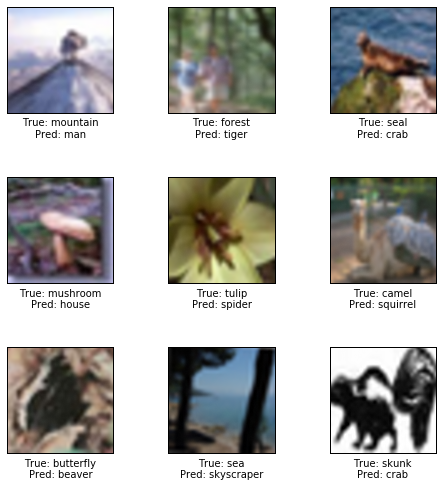

In [52]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=False)

### Convolutional Weights

Min:  -0.30551, Max:   0.30600
Mean: -0.00148, Stdev: 0.11377


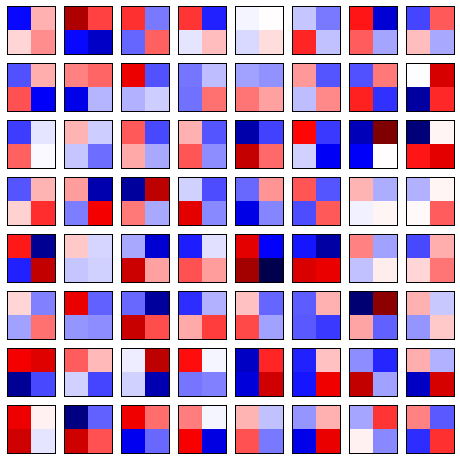

In [53]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -1.02866, Max:   0.70489
Mean: -0.00635, Stdev: 0.11809


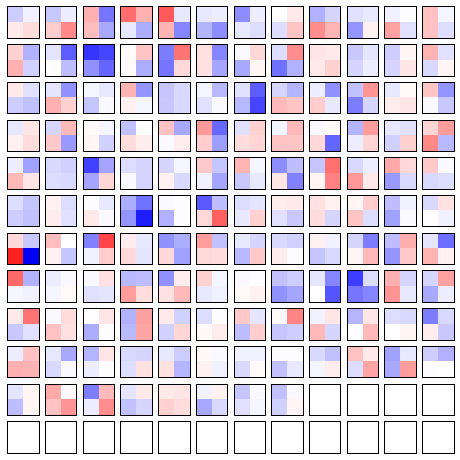

In [54]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers

In [55]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)
    plt.show()

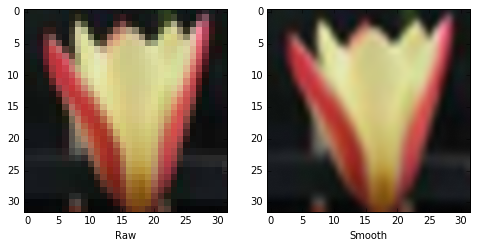

In [56]:
img, cls = get_test_image(16)
plot_image(img)

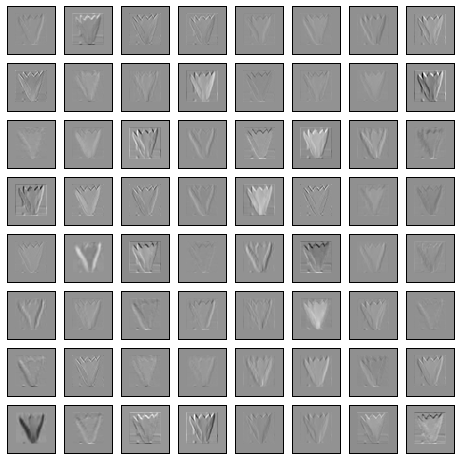

In [57]:
plot_layer_output(output_conv1, image=img)

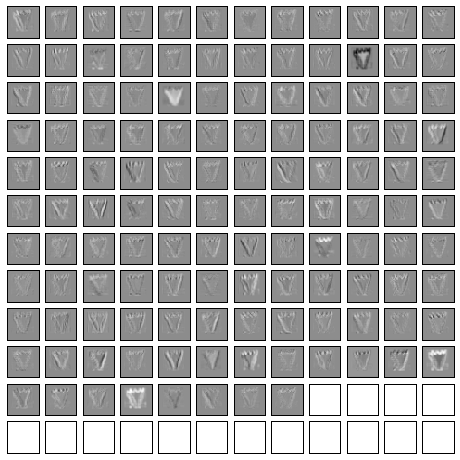

In [58]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels

In [59]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls], feed_dict={x: [img]})

In [60]:
np.set_printoptions(precision=3, suppress=True)

print(label_pred[0])

[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.001  0.     0.     0.     0.     0.     0.     0.     0.     0.001
  0.     0.     0.     0.     0.     0.     0.     0.024  0.     0.     0.
  0.     0.     0.     0.     0.027  0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.001  0.     0.     0.003  0.     0.     0.     0.
  0.     0.     0.     0.     0.939  0.     0.     0.     0.     0.     0.
  0.001]


In [61]:
class_names[92]

'tulip'

In [62]:
class_names[16]

'can'